# Remote files and fsspec caching 

Author: Luis Lopez [@betolink](https://github.com/betolink)

---


When working with large binary files stored in the cloud tools like fsspec play a critical role in abstracting file access. These tools are input/output drivers to file systems. Libraries that understand how to read these formats do not know anything about remote files and fsspec is in charge of translating byte requests to remote byte requests (HTTP). 

Most of the file formats in the scientific world were not designed for efficient cloud access as they require non-sequential reads, meaning client libraries can jump to specific byte ranges to read only what's needed, like a row group in a Parquet file or a variable slice in NetCDF. However, the way fsspec fetches data from remote sources is controlled by its caching strategy. This strategy determines how data is fetched, stored locally, and re-used. If this strategy isn't properly aligned with the access patterns of the file format, performance and reliability can (and will) quickly degrade.

Imagine reading a NetCDF file hosted on S3 with a default block cache of 5 MB. If a query requires multiple small reads scattered throughout the file, and each of these reads falls in a different 5 MB block, fsspec will repeatedly download new blocks, resulting in excessive data transfer and latency. Worse, if the file is very large and caching is disabled or limited (e.g. using simplecache with no chunk awareness), access may become painfully slow—or even fail if many tiny reads cause timeouts or bandwidth limits to be exceeded.

By tuning the cache size, choosing the right caching backend (like blockcache or filecache), and understanding how your format is read by your analysis tools (e.g., xarray, pandas, pyarrow), you can greatly reduce redundant downloads, improve throughput, and make interactive analysis over the cloud viable.

Aligning cache strategies on a per file basis is not a simple task, therefore earthaccess won't try to fine tune your requests except for changing the default behavior in fsspec from `readahead` to `blockcache` that offers better access patterns and a more efficient cache invalidation strategy for binary files. Based on file size earthaccess will cache starting at 4MB up to 16MB for very large files (more than 1GB). 

The max in-memory caching size will be 16MBx32 blocks = 512MB per file. All of this is configurable at runtime with the new `fsspec_open_kwargs` parameter. Some examples of the usage of this new config dictionary are detailed in this notebook.



* **Efficiency**: Avoids repeated downloads of the same data during random-access reads.
* **Performance**: Reduces latency and bandwidth usage, especially for cloud-hosted files.
* **Scalability**: Supports parallel or repeated access patterns without overloading remote servers.


## NetCDF and HDF5 files 

A considerable amount of remote sensing data is stored in HDF5 and NetCDF formats. They are hierarchical, self-describing formats widely used in Earth science due to their ability to store multidimensional arrays, metadata, and complex data structures efficiently. However, their design assumes relatively fast random access to local storage, which becomes a bottleneck when accessed over high-latency networks like HTTP or S3. 

HDF5 and NetCDF files are typically organized into chunks—contiguous blocks of data that are compressed and stored separately. When reading a subset of a dataset (e.g., a time slice or spatial region), only the relevant chunks should be fetched. But without proper caching, each byte-range request for a chunk can result in a separate HTTP GET request, leading to thousands of small requests (Ro to Rn in the figure) for large analyses.  The diagram below illustrates how traditional HDF5 access results in scattered, inefficient requests, while cloud-optimized layouts enable sequential or sparse access with fewer round trips: 

<img src="https://nsidc.github.io/cloud-optimized-icesat2/figures/figure-1.png" width="50%">


This is where fsspec's `blockcache` becomes essential. By aligning the cache block size with the HDF5/NetCDF chunk size (or a multiple thereof), we minimize redundant fetches and ensure that once a chunk is downloaded, it remains available for reuse during subsequent accesses. For example, if a NetCDF variable uses 1 MB chunks, a 4–16 MB block cache ensures that multiple chunks are retained per block, reducing round trips. 

Additionally, because HDF5 files often contain shared metadata (e.g., dimensions, attributes, group structures), caching the beginning of the file (where **some** of this metadata resides) can dramatically speed up repeated opens or inspections. earthaccess leverages blockcache with sensible defaults to preserve both data and metadata across requests, making workflows using xarray or h5py over S3 much more performant. 
 
### Cloud optimized files (Zarr / COG / etc / Co-HDF5) 

As cloud-native workflows mature, new formats and adaptations have emerged to address the limitations of traditional binary formats in object storage environments. These cloud-optimized formats are designed for efficient, parallel, and distributed access over HTTP/S3 with minimal latency. 

* Zarr: A chunked, compressed, and directory-structured format that natively supports cloud storage. Each chunk is stored as a separate object, enabling true parallel I/O and eliminating the need for byte-range requests. When used with fsspec, Zarr datasets can be read efficiently even with minimal caching, since each chunk is an independent resource. 

* Cloud Optimized GeoTIFF (COG): A GeoTIFF variant with internal tiling and overviews organized so that key image metadata is at the front of the file, and tiles are laid out sequentially. This allows fast previews and spatial subsetting via byte-range requests without downloading the entire file. 

* Co-HDF5 (Cloud-Optimized HDF5): An emerging pattern where HDF5 files are rechunked and reorganized to improve cloud access performance. This includes placing metadata at the beginning, aligning chunks to network block boundaries, and minimizing cross-chunk references. 
     

These formats work best when paired with intelligent caching strategies. While Zarr benefits less from large block caches (since each chunk is already a discrete object), COG and Co-HDF5 still rely heavily on byte-range requests and thus benefit significantly from blockcache with appropriately sized blocks. 

<img src="https://earthmover.io/wp-content/uploads/2025/05/image-1024x576.png" width="50%">

Credit: Earthmover ["What is Zarr"](https://earthmover.io/blog/what-is-zarr)


Ultimately, the key to high-performance cloud data access lies in matching the caching strategy to the data layout, access pattern, and underlying format. With earthaccess, we aim to provide defaults that "just work" while giving advanced users full control via **fsspec_open_kwargs** to tune behavior as needed.
 

>💡 Pro Tip: Always inspect your data’s chunking structure (e.g., using zarr.tree() or h5py.File(...).visititems()) before setting cache parameters. Aligning cache and chunk sizes can yield 10x+ performance improvements.


## xarray and earthaccess.open()


xarray has become the de facto library to open and analyze n-dimensional scientific data in Python, thus the use of fsspec to open our remote files has the advantage of being interoperable with any xarray backend(or file engine) that can accept "file-like" objects. 




In [1]:
import earthaccess as ea
import xarray as xr

ea.login()

In [2]:
results = ea.search_data(
    short_name= "ATL03",
    version="006",
    cloud_hosted=True,
    temporal=("2025-01","2025-08"),
    bounding_box = (33.98,31.19,34.65,31.51),
    count=1
)
results[0]

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L2A Global Geolocated Photon Data V006'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 30.33129, 'Latitude': 59.54487}, {'Longitude': 30.11056, 'Latitude': 59.53332}, {'Longitude': 30.24536, 'Latitude': 58.86549}, {'Longitude': 30.80853, 'Latitude': 55.88052}, {'Longitude': 31.36126, 'Latitude': 52.6346}, {'Longitude': 31.97566, 'Latitude': 48.65302}, {'Longitude': 32.49118, 'Latitude': 45.00559}, {'Longitude': 33.14906, 'Latitude': 39.98632}, {'Longitude': 33.74537, 'Latitude': 35.07838}, {'Longitude': 33.81097, 'Latitude': 34.30428}, {'Longitude': 33.86962, 'Latitude': 33.48722}, {'Longitude': 34.51283, 'Latitude': 27.78584}, {'Longitude': 34.60505, 'Latitude': 26.94837}, {'Longitude': 34.73108, 'Latitude': 26.95938}, {'Longitude': 34.63976, 'Latitude': 27.79693}, {'Longitude': 34.0042, 'Latitude': 33.49849}, {'Longitude': 33.94726, 'Latitude': 34.31101}, {'Longitude': 33.88286, 'Latitude': 35.08625}, {'Longitude': 33.2955, 'Latitude': 39.9975}, {'Longitude': 32.64982, 'Latitude': 45.01685}, {'Longitude': 32.14543, 'Latitude': 48.66418}, {'Longitude': 31.54599, 'Latitude': 52.64596}, {'Longitude': 31.00834, 'Latitude': 55.89201}, {'Longitude': 30.46204, 'Latitude': 58.87722}, {'Longitude': 30.33129, 'Latitude': 59.54487}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-04T00:36:08.119Z', 'EndingDateTime': '2025-01-04T00:44:37.835Z'}}
Size(MB): 517.1338815689087
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/006/2025/01/04/ATL03_20250104003608_02892602_006_01.h5']

Now that we have results from CMR we can open the files, in this case a single HDF5 level 2 (non gridded) swath. 
One thing that this particular collection will highlight is that when dealing with non cloud-optimized files each dimension and variable will add overhead on the range requests. ATL03 contains more than 900 of them, and if we use libraries like xarray that try eagerly to fetch metadata to decode variables and dimensions our `open_dataset()` operation in xarray will be exponentially slow. 

Let's open the file and inspect the new caching defaults from earthaccess!

In [3]:
file_handler = ea.open(results)[0] # only one item in the list
file_handler.f.cache


        <BlockCache:
            block size  :   8388608
            block count :   65
            file size   :   542254177
            cache hits  :   0
            cache misses:   0
            total requested bytes: 0>
        

Here we are seeing the new caching defaults when we open files using earthaccess, instead of `readahead` we are using the `blockcache` and earthaccess adjusted the block size to 8MB. This will helps us not re-fetching data when we in turn use `xr.open_dataset()`

In [4]:
%%time

# no engine defined, xarray will guess based on file type in this case h5netcdf
ds = xr.open_dataset(file_handler, group="/gt1l/heights") 
ds

CPU times: user 545 ms, sys: 178 ms, total: 723 ms
Wall time: 33.3 s


<xarray.Dataset> Size: 280MB
Dimensions:         (delta_time: 5595411, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 45MB 2025-01-04T00:36:08.1495...
    lat_ph          (delta_time) float64 45MB ...
    lon_ph          (delta_time) float64 45MB ...
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 22MB ...
    dist_ph_along   (delta_time) float32 22MB ...
    h_ph            (delta_time) float32 22MB ...
    pce_mframe_cnt  (delta_time) uint32 22MB ...
    ph_id_channel   (delta_time) uint8 6MB ...
    ph_id_count     (delta_time) uint8 6MB ...
    ph_id_pulse     (delta_time) uint8 6MB ...
    quality_ph      (delta_time) int8 6MB ...
    signal_conf_ph  (delta_time, ds_surf_type) int8 28MB ...
    weight_ph       (delta_time) uint8 6MB ...
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

### Better caching

xarray decoded a few variables here and touched many parts of the file, what does this mean regardless file access? if we inspect the cache again will see the number of requests made and how many of them hit a cached block. 

In [5]:
file_handler.f.cache


        <BlockCache:
            block size  :   8388608
            block count :   65
            file size   :   542254177
            cache hits  :   1762
            cache misses:   22
            total requested bytes: 184549376>
        

### Defaults are bad for random access: testing readahead on hdf5, ATL03 data

Now let's explore what happens with [fsspec defaults](https://github.com/fsspec/filesystem_spec/blob/master/fsspec/caching.py) by overriding the config with `open_kwargs`. 


In [6]:
default_fsspec_open = {
    "cache_type": "readahead",
    "block_size": 5 * 1024 * 1024 # 5MB
}

file_handler = ea.open(results, open_kwargs=default_fsspec_open)[0]
file_handler.f.cache


        <ReadAheadCache:
            block size  :   5242880
            block count :   0
            file size   :   542254177
            cache hits  :   0
            cache misses:   0
            total requested bytes: 0>
        

In [7]:
%%time

ds = xr.open_dataset(file_handler, group="/gt1l/heights")
# we print the cache info again
file_handler.f.cache

CPU times: user 6.06 s, sys: 1.54 s, total: 7.6 s
Wall time: 11min 2s



        <ReadAheadCache:
            block size  :   5242880
            block count :   0
            file size   :   542254177
            cache hits  :   1158
            cache misses:   604
            total requested bytes: 3120435184>
        

This we can see we requested an order of magnitude more information with considerable more cache misses despite the block_size being similar in size. Most of it is due how `readahead` does cache invalidation for random access.

Old defaults: 

* 3120435184 requested bytes
* 604 cache misses
* Wall time: 11min

New defaults:

* 184549376 requested bytes
* 22 cache misses
* Wall time: 29.7 s

In [8]:
print(f"{int(3120435184/184549376)} times more data requested.")

16 times more data requested.


Here we are seeing over an **order of magnitude improvement** without changing anything but the way we fetch data. Of course things can improve even further if we deal with netcdf/hdf5 files with less variables and/or especially with cloud-optimized hdf5. 

We can test that with version 7 of the same file.

In [9]:
results = ea.search_data(
    short_name= "ATL03",
    version="007",
    cloud_hosted=True,
    temporal=("2025-01","2025-08"),
    bounding_box = (33.98,31.19,34.65,31.51),
    count=1
)
results[0]

Collection: {'EntryTitle': 'ATLAS/ICESat-2 L2A Global Geolocated Photon Data V007'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 30.33127, 'Latitude': 59.54486}, {'Longitude': 30.11054, 'Latitude': 59.53332}, {'Longitude': 30.24491, 'Latitude': 58.86764}, {'Longitude': 30.80852, 'Latitude': 55.88052}, {'Longitude': 31.36205, 'Latitude': 52.62974}, {'Longitude': 31.97691, 'Latitude': 48.64423}, {'Longitude': 32.49116, 'Latitude': 45.00559}, {'Longitude': 33.14972, 'Latitude': 39.98092}, {'Longitude': 33.74529, 'Latitude': 35.07892}, {'Longitude': 33.81083, 'Latitude': 34.30684}, {'Longitude': 33.86879, 'Latitude': 33.49515}, {'Longitude': 34.51274, 'Latitude': 27.78657}, {'Longitude': 34.60504, 'Latitude': 26.94837}, {'Longitude': 34.73106, 'Latitude': 26.95938}, {'Longitude': 34.63967, 'Latitude': 27.79765}, {'Longitude': 34.00338, 'Latitude': 33.50641}, {'Longitude': 33.94713, 'Latitude': 34.31352}, {'Longitude': 33.88278, 'Latitude': 35.0868}, {'Longitude': 33.29615, 'Latitude': 39.99209}, {'Longitude': 32.64981, 'Latitude': 45.01684}, {'Longitude': 32.14665, 'Latitude': 48.65539}, {'Longitude': 31.54676, 'Latitude': 52.64109}, {'Longitude': 31.00833, 'Latitude': 55.892}, {'Longitude': 30.46161, 'Latitude': 58.87937}, {'Longitude': 30.33127, 'Latitude': 59.54486}]}}]}}}
Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2025-01-04T00:36:08.119Z', 'EndingDateTime': '2025-01-04T00:44:37.835Z'}}
Size(MB): 544.0
Data: ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2025/01/04/ATL03_20250104003608_02892602_007_01.h5']

In [10]:
file_handler = ea.open(results, open_kwargs=default_fsspec_open)[0]
file_handler.f.cache


        <ReadAheadCache:
            block size  :   5242880
            block count :   0
            file size   :   570425344
            cache hits  :   0
            cache misses:   0
            total requested bytes: 0>
        

In [11]:
%%time

ds = xr.open_dataset(file_handler, group="/gt1l/heights")
# we print the cache info again
file_handler.f.cache

CPU times: user 316 ms, sys: 55.7 ms, total: 371 ms
Wall time: 16.2 s



        <ReadAheadCache:
            block size  :   5242880
            block count :   0
            file size   :   570425344
            cache hits  :   1274
            cache misses:   13
            total requested bytes: 68816555>
        

### Wait, what happened now?

We didn't optimize the cache and yet this file in version 7 took only ~17 seconds to open, why? well this is a cloud optimized HDF5 file, hence all the metadata fits in the first request fsspec does. But this is not always the case, depending on how big a file is and how many variables and metadata has. Now we's use new earthaccess defaults and see if we can improve this even more. 

> Note that cloud optimized HDF5 and NetCDF is a very recent and for now not a lot of datasets will be released in this format 

In [12]:
%%time

# best case scenario, block caching on a cloud optimized hdf5 file.
file_handler = ea.open(results)[0]
ds = xr.open_dataset(file_handler, group="/gt1l/heights")

file_handler.f.cache

CPU times: user 217 ms, sys: 52.3 ms, total: 269 ms
Wall time: 6.71 s



        <BlockCache:
            block size  :   8388608
            block count :   68
            file size   :   570425344
            cache hits  :   1287
            cache misses:   3
            total requested bytes: 25165824>
        

## Benchmarks

* **`blockcache`** is better than `readahead` for binary files (hdf5, netcdf, hdf) that require random access. earthaccess now uses `blockcache` by default and the block size is adjusted by file size.
  * small files < 100MB: **4MB**
  * medium files < 1GB: **8MB**
  * big file: > 1GB: **16MB** 
* **optimal caching** depends very much on the access pattern and the internal chunking of a given dataset, as of now that information is not easily available beforehand, a database that contains this kind of information will be really helpful to the community.

Here is a table that shows the performance gains by this new caching schema for a few selected popular binary datasets in the NASA Earth archives.

**CAUTION**: Running this can take up to 1 hour if we are not in-region.


In [13]:
%%time

import time

import earthaccess as ea
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import xarray as xr

ea.login()

# Some popular NASA datasets
popular_collections = [
    "C2723758340-GES_DISC",     
    "C2724036633-LARC_CLOUD",    
    "C3385049989-OB_CLOUD",      
    "C2532426483-ORNL_CLOUD",
    "C2670138092-NSIDC_CPRD"
]

collection_labels = {
    "C2723758340-GES_DISC": "GPM Precipitation (GES DISC)",
    "C2724036633-LARC_CLOUD": "TEMPO L2 (LARC)",
    "C3385049989-OB_CLOUD": "PACE OCI (OB)",
    "C2532426483-ORNL_CLOUD": "Daymet daily (ORNL)",
    "C2670138092-NSIDC_CPRD": "ATL06 Lidar (NSIDC)"
}

def open_file(concept_id: str, optimized: bool, run_id: int = 0):
    default_fsspec_open = {
        "cache_type": "readahead",
        "block_size": 5 * 1024 * 1024  # 5MB
    }

    results = ea.search_data(concept_id=concept_id, cloud_hosted=True, count=1)
    if not results:
        return {
            "concept_id": concept_id,
            "optimized": optimized,
            "run_id": run_id,
            "time": None,
            "block_size": None,
            "file_size": None,
            "cache_hits": None,
            "cache_misses": None,
            "total_requested_bytes": None,
            "error": "No files found"
        }

    try:
        if not optimized:
            f_h = ea.open(results, open_kwargs=default_fsspec_open)[0]
        else:
            f_h = ea.open(results)[0]  # Uses earthaccess's blockcache + adaptive block size

        t_start = time.time()
        ds = xr.open_datatree(f_h, phony_dims='sort', decode_timedelta=True)
        execution_time = time.time() - t_start
        ds.close()

        
        cache = f_h.f.cache
        return {
            "concept_id": concept_id,
            "optimized": optimized,
            "run_id": run_id,
            "time": execution_time,
            "block_size": getattr(cache, 'blocksize', None),
            "file_size": getattr(cache, 'size', None),
            "cache_hits": getattr(cache, 'hit_count', 0),
            "cache_misses": getattr(cache, 'miss_count', 0),
            "total_requested_bytes": getattr(cache, 'total_requested_bytes', 0),
            "error": None
        }

    except Exception as e:
        return {
            "concept_id": concept_id,
            "optimized": optimized,
            "run_id": run_id,
            "time": None,
            "block_size": None,
            "file_size": None,
            "cache_hits": None,
            "cache_misses": None,
            "total_requested_bytes": None,
            "error": str(e)
        }



n_runs = 3
print(f"Starting benchmark: {n_runs} runs per dataset and mode\n")
benchmarks = []

for run in range(n_runs):
    print(f"Run {run + 1} of {n_runs}")

    # Optimized (earthaccess defaults)
    print("Optimized (blockcache)")
    for cid in tqdm.tqdm(popular_collections):
        result = open_file(cid, optimized=True, run_id=run)
        benchmarks.append(result)

    # Default (readahead)
    print("Non-optimized (readahead)")
    for cid in tqdm.tqdm(popular_collections):
        result = open_file(cid, optimized=False, run_id=run)
        benchmarks.append(result)


df = pd.DataFrame(benchmarks)

Starting benchmark: 3 runs per dataset and mode

Run 1 of 3
Optimized (blockcache)


100%|███████████████████████████████████████████████████████████████████████| 5/5 [01:42<00:00, 20.48s/it]


Non-optimized (readahead)


100%|██████████████████████████████████████████████████████████████████████| 5/5 [11:46<00:00, 141.24s/it]


Run 2 of 3
Optimized (blockcache)


100%|███████████████████████████████████████████████████████████████████████| 5/5 [01:49<00:00, 21.98s/it]


Non-optimized (readahead)


100%|██████████████████████████████████████████████████████████████████████| 5/5 [12:01<00:00, 144.28s/it]


Run 3 of 3
Optimized (blockcache)


100%|███████████████████████████████████████████████████████████████████████| 5/5 [01:36<00:00, 19.24s/it]


Non-optimized (readahead)


100%|██████████████████████████████████████████████████████████████████████| 5/5 [12:21<00:00, 148.27s/it]

CPU times: user 54.4 s, sys: 3.94 s, total: 58.3 s
Wall time: 41min 18s



SUMMARY: Averaged Over 3 Runs
                              Time (s) - Opt  Time (s) - Default  Speedup (x)  \
dataset                                                                         
ATL06 Lidar (NSIDC)                   10.357             507.886        49.04   
Daymet daily (ORNL)                    2.406               2.025         0.84   
GPM Precipitation (GES DISC)           4.206              57.330        13.63   
PACE OCI (OB)                          3.581              24.653         6.88   
TEMPO L2 (LARC)                       19.316              68.545         3.55   

                              Hit Rate - Opt  Hit Rate - Default  \
dataset                                                            
ATL06 Lidar (NSIDC)                    0.999               0.810   
Daymet daily (ORNL)                    0.998               0.998   
GPM Precipitation (GES DISC)           0.979               0.452   
PACE OCI (OB)                          0.990               0.

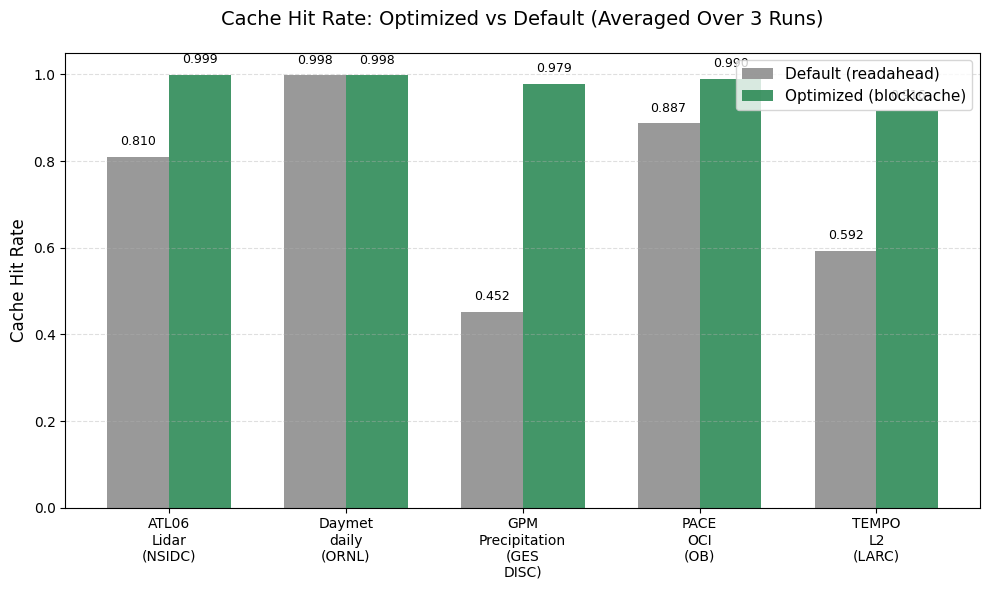

In [17]:
df["dataset"] = df["concept_id"].map(collection_labels)
df["mode"] = df["optimized"].map({True: "Optimized", False: "Default (readahead)"})
df["file_size_mb"] = df["file_size"] / (1024 * 1024)
df["total_requests"] = df["cache_hits"] + df["cache_misses"]
df["hit_rate"] = df["cache_hits"] / df["total_requests"].where(df["total_requests"] > 0, 1)
df["requested_mb"] = df["total_requested_bytes"] / (1024 * 1024)


success_df = df[df["error"].isna()].copy()
failed = df[df["error"].notna()]

if len(failed) > 0:
    print(failed[["dataset", "mode", "run_id", "error"]].drop_duplicates())

if len(success_df) == 0:
    raise RuntimeError("All tests failed. Check authentication and connectivity.")

# Average metrics over n runs
grouped = success_df.groupby(['dataset', 'mode']).agg(
    time_mean=('time', 'mean'),
    time_std=('time', 'std'),
    hit_rate_mean=('hit_rate', 'mean'),
    requested_mb_mean=('requested_mb', 'mean'),
    block_size=('block_size', 'first'),  # should be stable
    file_size_mb=('file_size_mb', 'first')
).reset_index()


pivot = grouped.pivot(index='dataset', columns='mode')
pivot.columns = [f"{metric}_{mode}" for metric, mode in pivot.columns]
pivot = pivot.sort_index()


pivot['speedup_x'] = (pivot['time_mean_Default (readahead)'] / pivot['time_mean_Optimized']).round(2)
pivot['data_savings_%'] = (
    (pivot['requested_mb_mean_Default (readahead)'] - pivot['requested_mb_mean_Optimized']) /
    pivot['requested_mb_mean_Default (readahead)'] * 100
).round(1)


final_cols = [
    'time_mean_Optimized', 'time_mean_Default (readahead)', 'speedup_x',
    'hit_rate_mean_Optimized', 'hit_rate_mean_Default (readahead)',
    'requested_mb_mean_Optimized', 'requested_mb_mean_Default (readahead)', 'data_savings_%',
    'block_size_Optimized', 'block_size_Default (readahead)', 'file_size_mb_Optimized'
]

summary = pivot[final_cols].copy()

summary.rename(columns={
    'time_mean_Optimized': 'Time (s) - Opt',
    'time_mean_Default (readahead)': 'Time (s) - Default',
    'speedup_x': 'Speedup (x)',
    'hit_rate_mean_Optimized': 'Hit Rate - Opt',
    'hit_rate_mean_Default (readahead)': 'Hit Rate - Default',
    'requested_mb_mean_Optimized': 'Req MB - Opt',
    'requested_mb_mean_Default (readahead)': 'Req MB - Default',
    'data_savings_%': 'Data Saved (%)',
    'block_size_Optimized': 'Block MB - Opt',
    'block_size_Default (readahead)': 'Block MB - Default',
    'file_size_mb_Optimized': 'File Size (MB)'
}, inplace=True)


for col in ['Block MB - Opt', 'Block MB - Default']:
    summary[col] = (summary[col] / (1024*1024)).round(1)

# Summary
print("\n" + "="*100)
print(f"SUMMARY: Averaged Over {n_runs} Runs")
print("="*100)
print(summary.round(3))

# Cache Hit Rate Comparison

plot_data = grouped.set_index(['dataset', 'mode'])['hit_rate_mean'].unstack('mode')
datasets = plot_data.index
x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, plot_data['Default (readahead)'], width, label='Default (readahead)', color='gray', alpha=0.8)
bars2 = plt.bar(x + width/2, plot_data['Optimized'], width, label='Optimized (blockcache)', color='seagreen', alpha=0.9)

plt.ylabel('Cache Hit Rate', fontsize=12)
plt.title('Cache Hit Rate: Optimized vs Default (Averaged Over 3 Runs)', fontsize=14, pad=20)
plt.xticks(x, [lbl.replace(' ', '\n') for lbl in datasets], rotation=0)
plt.ylim(0, 1.05)
plt.legend(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.4)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.02,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

### TL;DR; `earthaccess.open()` then vs now

All of this to say that with the upcoming release of earthaccess we'll enjoy speedups in our workflows from marginal to order of magnitude depending on the dataset.


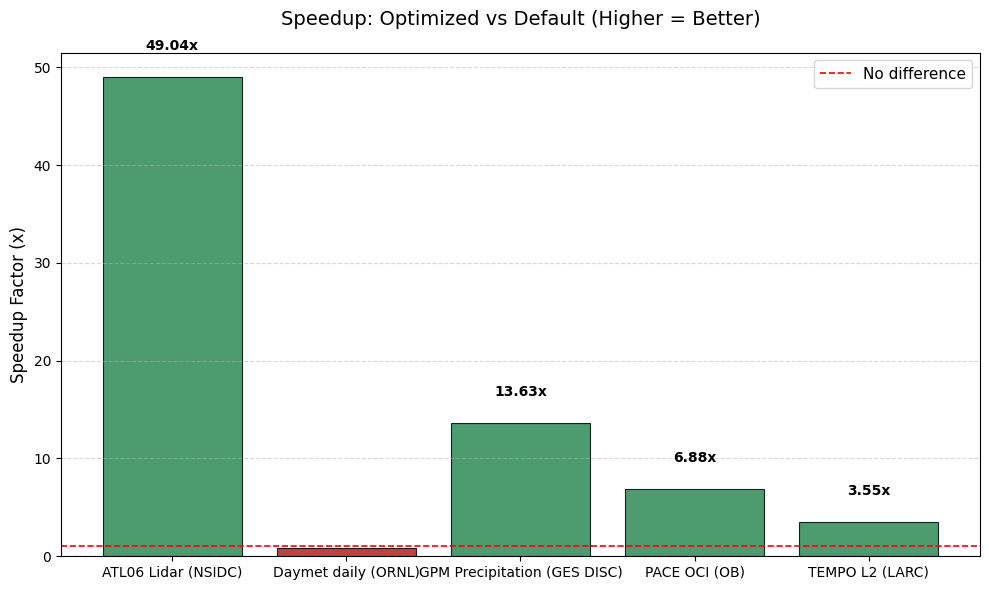

In [18]:
plt.figure(figsize=(10, 6))

# Extract data
speedup_values = summary["Speedup (x)"].values
datasets = summary.index

# Color: red if < 1.0 (slower), green if >= 1.0 (faster)
colors = ['firebrick' if s < 1.0 else 'seagreen' for s in speedup_values]

bars = plt.bar(datasets, speedup_values, color=colors, alpha=0.85, edgecolor='black', linewidth=0.8)

# Labels and title
plt.ylabel('Speedup Factor (x)', fontsize=12)
plt.title('Speedup: Optimized vs Default (Higher = Better)', fontsize=14, pad=20)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.axhline(1.0, color='red', linestyle='--', linewidth=1.2, label='No difference')

# Add value labels on bars
for bar, speedup in zip(bars, speedup_values):
    color = 'white' if speedup < 1.0 else 'black'
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + max(speedup_values) * 0.05,
        f'{speedup:.2f}x',
        ha='center',
        va='bottom',
        fontsize=10,
        color=color,
        fontweight='bold'
    )

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()